# Perceptual Correspondence

*Code to create Figure 3h in [Saliency Cards: A Framework to Characterize and Compare
Saliency Methods](https://arxiv.org/abs/2206.02958).*

Perceptual correspondence measures if the perceived signal in the saliency map accurately reflects the feature importance. For example, saliency maps with high perceptual correspondence should not contain visual artifacts that lead users to see signal where there isn't any.

To illustrate perceptual correspondence, we apply saliency methods to an untrained model, showing that while [vanilla gradients](https://arxiv.org/abs/1312.6034) looks appropriately random [integrated gradients](https://arxiv.org/abs/1703.01365) could cause a user to percieve unwarranted signal.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import torch

from saliency_methods.vanilla_gradients import VanillaGradients
from saliency_methods.integrated_gradients import IntegratedGradients
from saliency_methods.util import visualize_saliency
from util import imagenet_transform, imagenet_normalize, load_model_from_pytorch, load_pil_image

## Load Mammography Image and Untrained ResNet50 Model
In this example we compute the saliency of a resnet50 model that has not been trained.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_model_from_pytorch('resnet50', False, device).eval()

We select an mammograph image from [CBIS-DDSM](https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=22516629) to evaluate.

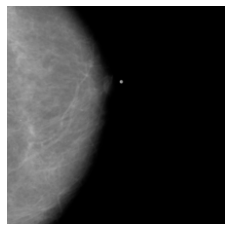

In [4]:
image_path = './resources/mammogram.png'
image = load_pil_image(image_path)

model_transform = imagenet_transform(normalize=True)
display_transform = imagenet_transform(normalize=False)

image_input = model_transform(image)
plt.imshow(display_transform(image).numpy().transpose(1, 2, 0))
plt.axis('off');

## Compare Vanilla Gradients to Integrated Gradients
We compare the saliency maps from [vanilla gradients](https://arxiv.org/abs/1312.6034) to [integrated gradients](https://arxiv.org/abs/1703.01365). Since this model has not been trained, it does not know anything about mammograms and its decisions are random guesses. Thus, a saliency method with perceptual correspondence should look appropriately random. 

In [5]:
image_batch = image_input.unsqueeze(0).to(device)

The saliency map for vanilla gradients looks random, so it is perceptually correspondent with the model's random guess.

/nobackup/users/aboggust/bin/miniconda3/envs/wml/lib/python3.6/site-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


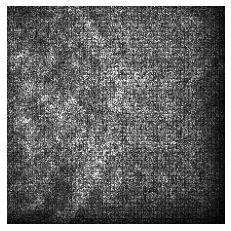

In [6]:
vg = VanillaGradients(model)
vg_saliency = vg.get_saliency(image_batch)
visualize_saliency(vg_saliency, scheme='grayscale', absolute_values=True);

However, integrated gradients with a black baseline highlights only the breast tissue. This is problematic because a user interpreting the saliency could believe the model has learned something about interpreting mammographs and is using features of the breast tissue to make its decisions.

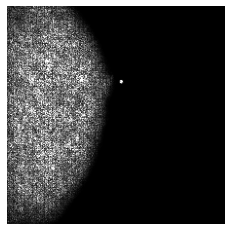

In [7]:
ig = IntegratedGradients(model)
black_baseline = imagenet_normalize()(torch.zeros(image_batch.shape[1:])).unsqueeze(0)
ig_saliency = ig.get_saliency(image_batch, baseline=black_baseline)
visualize_saliency(ig_saliency, scheme='grayscale', absolute_values=True);